# End-to-End Biomedical Image Analytics using Machine Learning and Artificial Intelligence for Lung Nodule Classification in SAS Viya

This notebook demonstrates how to build an end-to-end solutions in SAS Viya that can assist with a real-world biomedical image analytics problem, specifically lung nodule classification that is based on 3-D CT images of patient torsos and radiologist annotations of nodule locations. Lung nodules are lumps of dead tissue that commonly occur in humans, less than 5% of which are malignant. Radiologists are responsible for determining whether a nodule visually observed in a patient image is potentially cancerous so that a definitive test such as biopsy is performed for that patient. This demo focuses on nodule shape, one of many factors that radiologists account for in their classification. The basis for a shape-based classification is the irregular protrusions (called spiculations) that commonly exist on the surfaces of malignant nodules. Benign nodules, on the other hand, have smooth and spherical surfaces more often than not. Two solutions, one based on machine learning, and the other on artificial intelligence, are presented.

# Imports

In [1]:
import sys
stdout = sys.stdout
stderr = sys.stderr
import cv2
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import struct
import swat
import swat.datamsghandlers as dmh
import time
from IPython.display import display
from mayavi import mlab
from sklearn import model_selection, metrics
from tabulate import tabulate
from IPython.display import HTML
from random import randint
sys.stdout = stdout
sys.stderr = stderr

%matplotlib inline

# Server and Data Locations

## CAS Server

In [5]:
cashost = 'localhost'
casport = 11943

## Data Locations (Please see slide 6 below for information on data sources)

In [3]:
lcdemo_path = '<path to the root dir of images and annotations>'  # Lung cancer medical images and radiologist annotations
caslib_name = 'lcdemo'
lcdemo_subdir = ''
slides_dir = '<relative path to slides images>'  # Slides

# Helper Functions

In [4]:
def reverse(a, axis=0):
    """Reverses an numpy array along a given axis."""
    idx = [slice(None)] * len(a.shape)
    idx[axis] = slice(None, None, -1)
    return a[idx]

def display_slide(binaries, paths, width, height, n):
    """Displays nth slide."""
    slide_path = lcdemo_path + slides_dir + ('Slide%s.PNG' % n)
    pos = np.where(paths == slide_path)[0][0]
    slide_image = bytearray(binaries[pos])
    slide_image = np.reshape(slide_image, (height, width, 4))[:, :, 0:3]
    slide_image = reverse(slide_image, 2)
    plt.figure(figsize = (15, 30))
    plt.imshow(slide_image)
    plt.show()

def display_image_pair(image1, image2):
    """Displays a pair of images."""
    fig = plt.figure(figsize=(10, 10. / image1.shape[1] * image1.shape[0]))
    fig.add_subplot(121)
    plt.imshow(np.squeeze(image1))
    plt.gray()
    plt.xticks([0, image1.shape[1]], fontsize=15)
    plt.yticks([0, image1.shape[0]], fontsize=15)
    fig.add_subplot(122)
    plt.imshow(np.squeeze(image2))
    plt.gray()
    plt.xticks([0, image2.shape[1]], fontsize=15)
    plt.yticks([0, image2.shape[0]], fontsize=15)
    plt.show()

def display_image_pair_from_table(table, channels, where1, where2):
    """Fetch two images from a CAS table according to provided where-clauses and display them."""
    # Fetch image binaries, and related data
    fetched_images = table.query(where1)[['_resolution_', '_image_']]\
                                .sort_values('_path_').to_frame()
    image_resolutions = fetched_images['_resolution_']
    image_binaries = fetched_images['_image_']
    res = np.fromstring(image_resolutions[0], np.int64)
    image1 = bytearray(image_binaries[0][0:channels * res[0] * res[1]])
    image1 = np.reshape(image1, (res[1], res[0], channels))
    
    fetched_images = table.query(where2)[['_resolution_', '_image_']]\
                                .sort_values('_path_').to_frame()
    image_resolutions = fetched_images['_resolution_']
    image_binaries = fetched_images['_image_']
    res = np.fromstring(image_resolutions[0], np.int64)
    image2 = bytearray(image_binaries[0][0:channels * res[0] * res[1]])
    image2 = np.reshape(image2, (res[1], res[0], channels))
    display_image_pair(image1, image2)

def get_information(directory):
    """Get some information about files in a directory."""
    file_list = []
    for i in os.listdir(directory):
        a = os.stat(os.path.join(directory,i))
        file_list.append([i,time.ctime(a.st_mtime),time.ctime(a.st_ctime)])
    return file_list

def find_optimal_cutoff(target, predicted, plabel):
    """Find optimal cut-off based on ROC analyses."""
    fpr, tpr, threshold = metrics.roc_curve(target, predicted, pos_label=plabel)
    i = np.arange(len(tpr)) 
    roc = pd.DataFrame({'tf' : pd.Series(-tpr - (1 - fpr), index=i), 'threshold' : pd.Series(threshold, index=i)})
    roc_t = roc.ix[(roc.tf).argsort()[:1]]
    return list(roc_t['threshold']), fpr, tpr, threshold

def sort_label_ids_by_position(ids, paths, lbls, poss, ors, label):
    """Sort labels and ids of images according to their position."""
    inds = np.array(lbls == label)
    ids = np.array(ids)[inds]
    paths = np.array(paths)[inds]
    poss = np.array(poss)[inds]
    ors = np.array(ors)[inds]
    poss = np.array([struct.unpack('=3d', poss[i]) for i in range(poss.size)])
    ors = np.array([struct.unpack('=9d', ors[i]) for i in range(ors.size)])
    zdir = ors[0].reshape(3, 3)[:, 2]
    pros = np.array([np.dot(poss[i], zdir) for i in range(len(poss))])
    sinds = np.argsort(pros)[::-1]
    return ids[sinds], paths[sinds]

def get_image_array(image_binaries, dimensions, resolutions, formats, n):
    """Get a 3D image from CAS table."""
    dimension = dimensions[n]
    resolution = np.array(struct.unpack('=%sq' % dimension, resolutions[n][0:dimension * 8]))
    resolution = resolution[::-1]
    myformat = formats[n]
    num_cells = np.prod(resolution)
    if myformat == '16U' or myformat == '16S':
        image_array = np.array(struct.unpack('=%sh' % num_cells, image_binaries[n][0:2 * num_cells]))
        image_array = np.reshape(image_array, resolution)
    elif myformat == '8U' or myformat == '8S':
        image_array = np.array(bytearray(image_binaries[n][0:num_cells]))
        image_array = np.reshape(image_array, resolution)
    else:
        image_array = np.array(bytearray(image_binaries[n]))
        image_array = np.reshape(image_array, (resolution[0], resolution[1], 3))
        image_array = reverse(image_array, 2)
    return image_array

def mapping(val):
    """A simple mapping from int to int."""
    if (val == 0):
        return 2
    elif (val == 2):
        return 0
    else:
        return val

def display_slice_3d(images, dims, ress, fmts, poss, oris, scas, perm, image_index, slice_index, rf):
    """Display an image slice in 3D."""
    image = get_image_array(images, dims, ress, fmts, image_index)
    geo_perm = np.zeros(3, dtype=np.int)
    for i in range(3):
        geo_perm[mapping(i)] = mapping(perm[i])
    image = np.transpose(image, perm)
    image = image[slice_index, :, :]
    nr, nc = image.shape[:2]
    dimension = dims[image_index]
    pos = np.array(struct.unpack('=%sd' % dimension, poss[image_index]))
    sca = np.array(struct.unpack('=%sd' % dimension, scas[image_index][0:8 * dimension]))
    ori = np.array(struct.unpack('=%sd' % (dimension*dimension), oris[image_index][0:8 * dimension * dimension]))
    xx, yy = np.meshgrid(np.linspace(0, nc, nc), np.linspace(0, nr, nr))
    zz = np.zeros((nr, nc))
    lc = np.vstack((np.reshape(xx, (1, nc*nr)), np.reshape(yy, (1, nc*nr)), np.reshape(zz, (1, nc*nr))))
    ori = np.reshape(ori, (3, 3))
    ori = ori[:, geo_perm]
    sca = sca[geo_perm]
    pos = pos + slice_index * sca[2] * ori[:, 2]
    pos = np.reshape(pos, (3, 1))
    sca = np.diag(sca)
    gc = np.matmul(ori, np.matmul(sca, lc))
    gc = gc + np.matmul(pos, np.ones((1, nc*nr)))
    mlab.mesh(np.reshape(gc[0, :], (nr, nc)), np.reshape(gc[1, :], (nr, nc)), np.reshape(gc[2, :], (nr, nc)), 
              scalars = image, colormap='gray')
    if (rf):
        for i in range(3):
            clr=((i == 0) * 1, (i == 1) * 1, (i == 2) * 1)
            mlab.quiver3d(pos[0], pos[1], pos[2], ori[0, i], ori[1, i], ori[2, i], 
                          line_width=5, scale_factor=50*sca[i, i], color=clr, mode='arrow')

def load_slides(cas_session, slides_table):
    """Load the slides."""
    casout = s.CASTable(slides_table, replace=True)
    s.image.loadimages(path=slides_dir, caslib=caslib_name, casout=casout, decode=True)
    fetched_slides = casout[['_resolution_', '_image_', '_path_']].to_frame()
    slide_binaries = fetched_slides['_image_']
    slide_resolutions = fetched_slides['_resolution_']
    slide_paths = fetched_slides['_path_']
    res = np.fromstring(slide_resolutions[0], np.int64)
    slide_width = res[0]
    slide_height = res[1]
    return slide_binaries, slide_paths, slide_width, slide_height

# Connect to CAS Server

In [6]:
s = swat.CAS(cashost, casport)

s.loadactionset('image')
s.loadactionset('biomedimage')
s.loadactionset('deeplearn')

s.addcaslib(name=caslib_name, path=lcdemo_path, subdirectories=True, datasource='path')
s.setsessopt(caslib=caslib_name, logflushtime=0)

if s.about()['About']['System']['OS Family'] == 'WIN':
    slash='\\'
else:
    slash='/'

NOTE: Added action set 'image'.
NOTE: Added action set 'biomedimage'.
NOTE: Added action set 'deeplearn'.
NOTE: 'lcdemo' is now the active caslib.
NOTE: Cloud Analytic Services added the caslib 'lcdemo'.
NOTE: 'lcdemo' is now the active caslib.
NOTE: Grid node action status report: 1 nodes, 23 total actions executed.


# <font color='green'>(Prerun)</font> Load Slides

NOTE: Loaded 18 images from \\bbnfs01.unx.sas.com\ifs\fvcc\BMIData\DemoData\LungNoduleClassification\sgf2018\ into Cloud Analytic Services table slides.


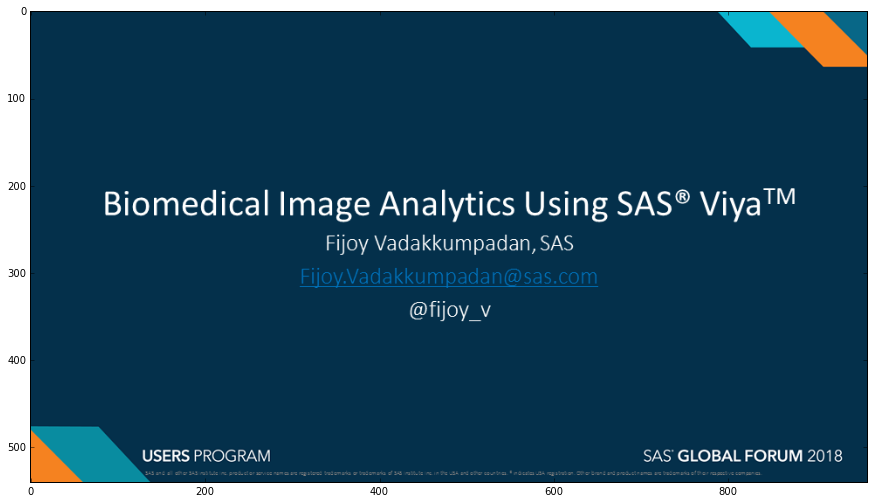

In [7]:
slide_binaries, slide_paths, slide_width, slide_height = load_slides(s, 'slides')
display_slide(slide_binaries, slide_paths, slide_width, slide_height, 1)

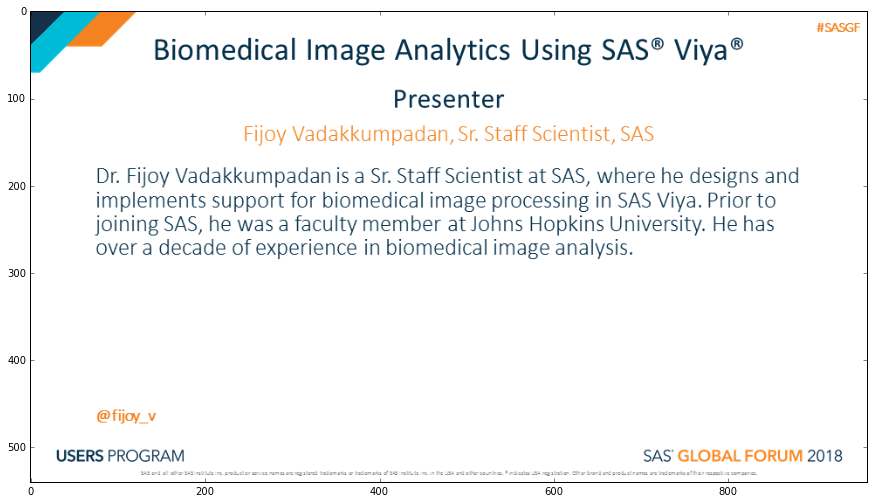

In [8]:
display_slide(slide_binaries, slide_paths, slide_width, slide_height, 2)

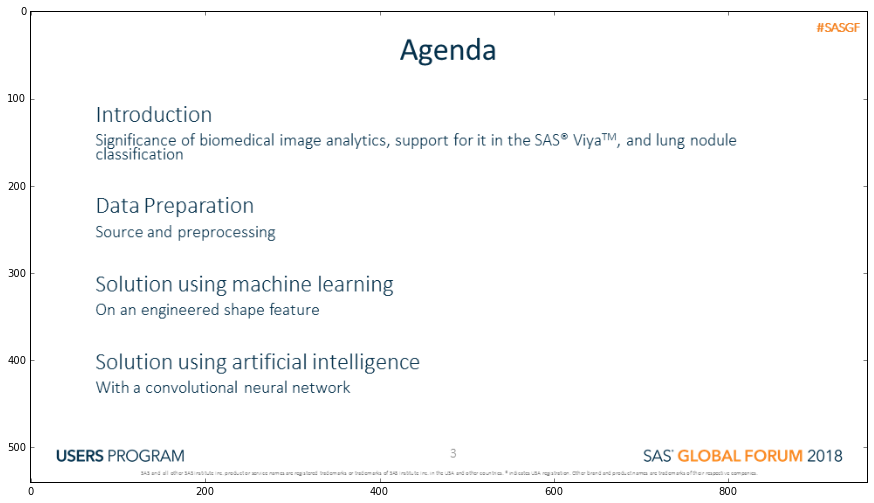

In [9]:
display_slide(slide_binaries, slide_paths, slide_width, slide_height, 3)

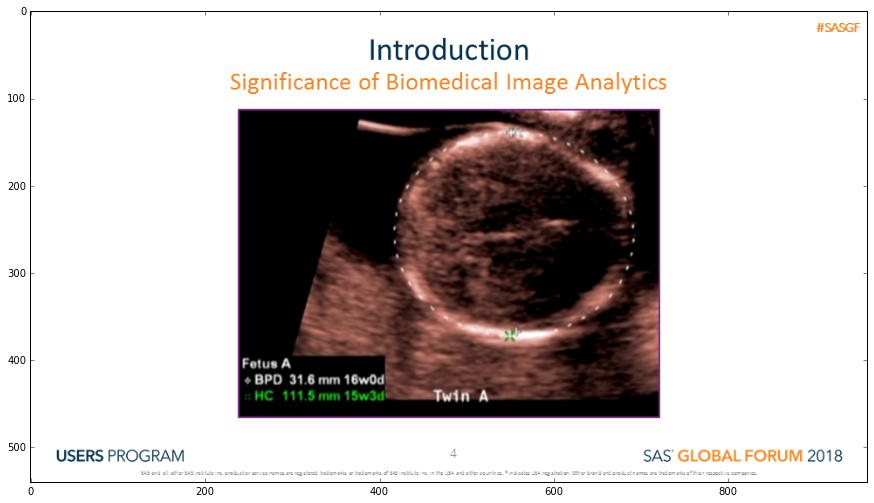

In [10]:
display_slide(slide_binaries, slide_paths, slide_width, slide_height, 4)

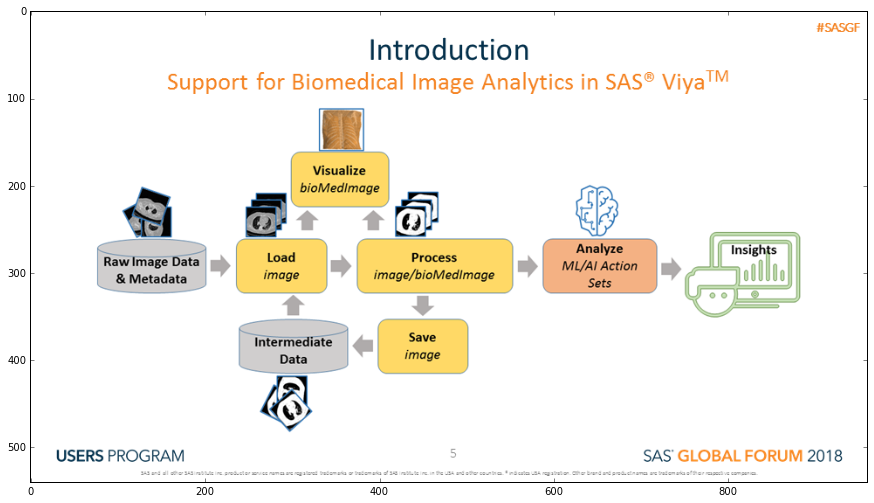

In [11]:
display_slide(slide_binaries, slide_paths, slide_width, slide_height, 5)

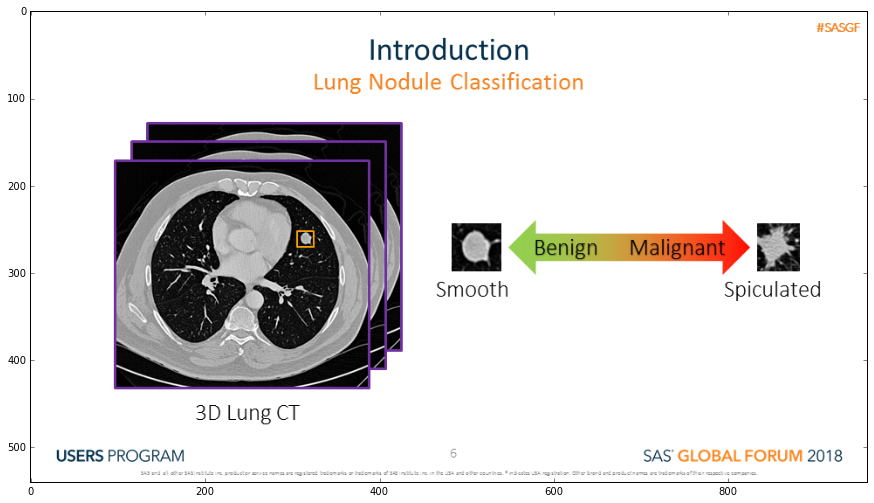

In [12]:
display_slide(slide_binaries, slide_paths, slide_width, slide_height, 6)

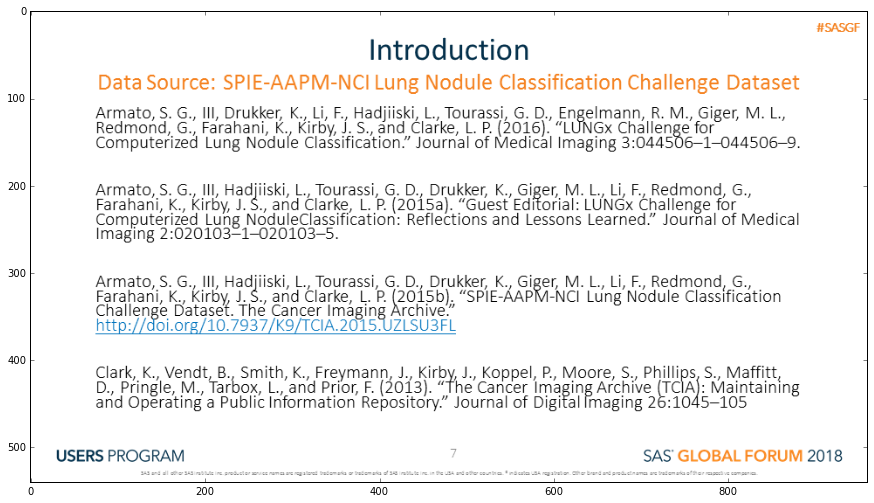

In [13]:
display_slide(slide_binaries, slide_paths, slide_width, slide_height, 7)

# <font color='green'>(Prerun)</font> Load All Patient 3D Images & Metadata (DICOM)

In [14]:
orig_medical = s.CASTable('origMedical', replace=True)

s.image.loadimages(path='TrainDataOriginal',
                   caslib=caslib_name,
                   casout=orig_medical,
                   addcolumns=dict(general=['width', 'height', 'depth', 'channeltype', 'position', 'orientation', 'spacing'],
                                   dicomAttributes=dict(keywords=['PatientAge', 'PatientSex', 'AcquisitionDate'])),
                   recurse=True,
                   series=dict(dicom=True),
                   labellevels=1,
                   decode=True)

NOTE: Loaded 10 images from \\bbnfs01.unx.sas.com\ifs\fvcc\BMIData\DemoData\LungNoduleClassification\TrainDataOriginal into Cloud Analytic Services table origMedical.


+ Elapsed: 197s, user: 25s, sys: 18s, mem: 1.78e+03mb

# Fetch and Display Example Patient Image with Malignant Lung Nodule

### <font color='green'>(Prerun)</font> Fetch

In [15]:
pid = "CT-Training-LC009"
example_rows = orig_medical.query("_label_='"+pid+"'").to_frame()

display(example_rows[['_PatientAge_', '_PatientSex_', '_AcquisitionDate_', '_width_', '_height_', '_depth_']])

medical_dimensions = example_rows['_dimension_']
medical_formats = example_rows['_channelType_']
medical_binaries = example_rows['_image_']
medical_resolutions = example_rows['_resolution_']
medical_channel_types = example_rows['_channelType_']
medical_image_array_exp = get_image_array(medical_binaries, medical_dimensions, medical_resolutions, medical_formats, 0)

,_PatientAge_,_PatientSex_,_AcquisitionDate_,_width_,_height_,_depth_
0,063Y,F,20070103,512,512,281


### Display

In [16]:
sf = mlab.pipeline.scalar_field(medical_image_array_exp)
mlab.pipeline.image_plane_widget(sf, plane_orientation='x_axes', slice_index=50, colormap='gray')
mlab.pipeline.image_plane_widget(sf, plane_orientation='y_axes', slice_index=100, colormap='gray')
mlab.pipeline.image_plane_widget(sf, plane_orientation='z_axes', slice_index=100, colormap='gray')
mlab.show()

# Load & Prepare Radiologist Annotations of All Patients

## Load, Fetch, & display

In [17]:
train_labels = s.CASTable('trainlabels', replace=True)

s.load_path('%s%s' % (lcdemo_subdir, 'trainAnnotations.csv'),
            importoptions=dict(filetype='csv', getnames=True),
            casout=train_labels)

fetched_labels = train_labels.sort_values('PatientID').to_frame()
n_patients = len(fetched_labels)
display(fetched_labels)

# Extract the Annotations for Later Use
patient_ids = fetched_labels['PatientID']
X = fetched_labels['NoduleX']
Y = fetched_labels['NoduleY']
W = fetched_labels['NoduleW']
H = fetched_labels['NoduleH']
Z_orig = fetched_labels['NoduleZ'].copy()
Z = fetched_labels['NoduleZ'].copy()
diagnosis = fetched_labels['Diagnosis']

# Adjust Z-coordinates of Nodules for Image Depth
fetched_rows = orig_medical[['_depth_', '_label_']].sort_values('_label_').to_frame()

medical_depths = fetched_rows["_depth_"]
for psn in range(n_patients):
    Z[psn] = medical_depths[psn]-Z_orig[psn]

,PatientID,NoduleX,NoduleY,NoduleZ,NoduleW,NoduleH,Diagnosis
0,CT-Training-BE001,396.0,288.0,169.0,12.0,12.0,benign
1,CT-Training-BE007,371.0,190.0,194.0,29.0,32.0,benign
2,CT-Training-LC002,132.0,352.0,70.0,14.0,14.0,malignant
3,CT-Training-LC003,365.0,314.0,70.0,19.0,19.0,malignant
4,CT-Training-LC009,129.0,279.0,63.0,39.0,43.0,malignant
5,LUNGx-CT002,311.0,328.0,205.0,37.0,37.0,benign
6,LUNGx-CT003,359.0,359.0,146.0,31.0,31.0,malignant
7,LUNGx-CT009,165.0,200.0,164.0,19.0,19.0,benign
8,LUNGx-CT019,114.0,345.0,131.0,36.0,36.0,malignant
9,LUNGx-CT024,97.0,274.0,197.0,20.0,20.0,benign


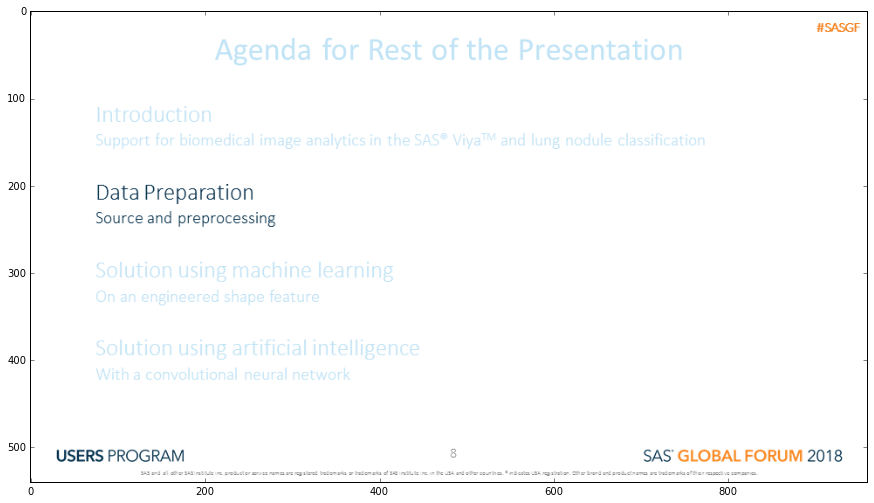

In [18]:
display_slide(slide_binaries, slide_paths, slide_width, slide_height, 8)

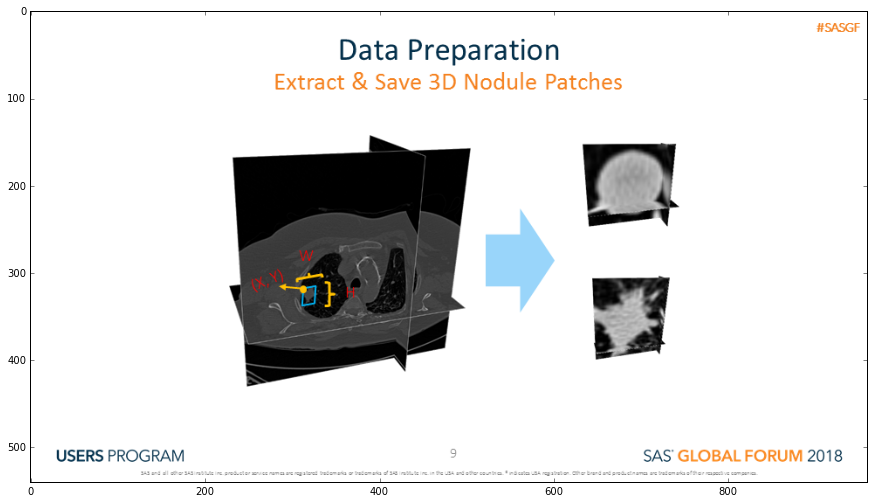

In [19]:
display_slide(slide_binaries, slide_paths, slide_width, slide_height, 9)

## <font color='green'>(Prerun)</font> Extract & Save 3D Patches Containing Nodules

In [20]:
s.setsessopt(messageLevel='NONE')
delta_z = 5
nodule_region = s.CASTable('noduleRegion', replace=True)

print('Saving 3D nodule patch (' + str(2*delta_z+1) + ' slices) of ...', flush=True)

for psn in range(n_patients):
    print(patient_ids[psn])
    
    # Extract the nodule region from the patient image into a temporary CAS table
    wclause = "_label_='" + patient_ids[psn] + "'"
    res=s.biomedimage.processbiomedimages(images=dict(table=orig_medical.query(wclause)),
                                          steps=[dict(stepparameters=dict(steptype='crop', 
                                                                          cropparameters=dict(croptype='basic', 
                                                                                              imagesize=[W[psn], 
                                                                                                         H[psn], 
                                                                                                         2*delta_z+1],
                                                                                              pixelIndex=[X[psn], 
                                                                                                          Y[psn], 
                                                                                                          Z[psn]-delta_z]))),
                                                 dict(stepparameters=dict(steptype='rescale', 
                                                                          rescaleparameters=dict(rescaletype='channeltype_8u')))],
                                          decode=True,
                                          copyVars=["_label_", "_path_", "_type_"],
                                          addColumns=["position", "orientation", "spacing"],
                                          casOut=nodule_region)

    # Save the nodule region as 3D images with metadata
    res=s.image.saveimages(images=dict(table=nodule_region, path='_path_'),
                           caslib=caslib_name, 
                           subdirectory=lcdemo_subdir + 'TrainDataNoduleRegions/' + diagnosis[psn],
                           type='nii',
                           labellevels=1)
    
print('All done', flush=True)

Saving 3D nodule patch (11 slices) of ...
CT-Training-BE001
CT-Training-BE007
CT-Training-LC002
CT-Training-LC003
CT-Training-LC009
LUNGx-CT002
LUNGx-CT003
LUNGx-CT009
LUNGx-CT019
LUNGx-CT024
All done


## <font color='green'>(Prerun)</font> Load All 3D Nodule Patches. Display Examples in 2D.

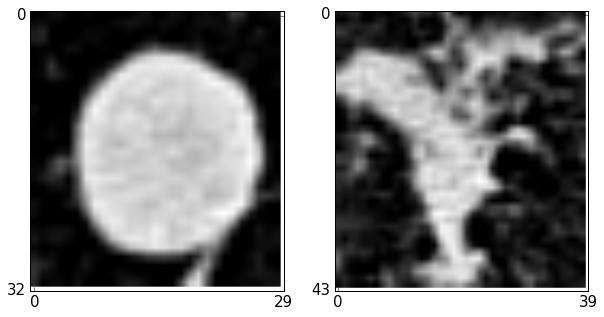

In [21]:
nodules_3d = s.CASTable(name='nodules3D', replace=True)

r = s.image.loadimages(casout=nodules_3d,
                       path='TrainDataNoduleRegions',
                       caslib=caslib_name,
                       recurse=True,
                       addcolumns=["position", "orientation", "spacing", "channeltype"],
                       labellevels=2,
                       decode=True)

display_image_pair_from_table(nodules_3d, 1, 
                              "_label_='benign" + slash + "CT-Training-BE007'", 
                              "_label_='malignant" + slash + "CT-Training-LC009'")

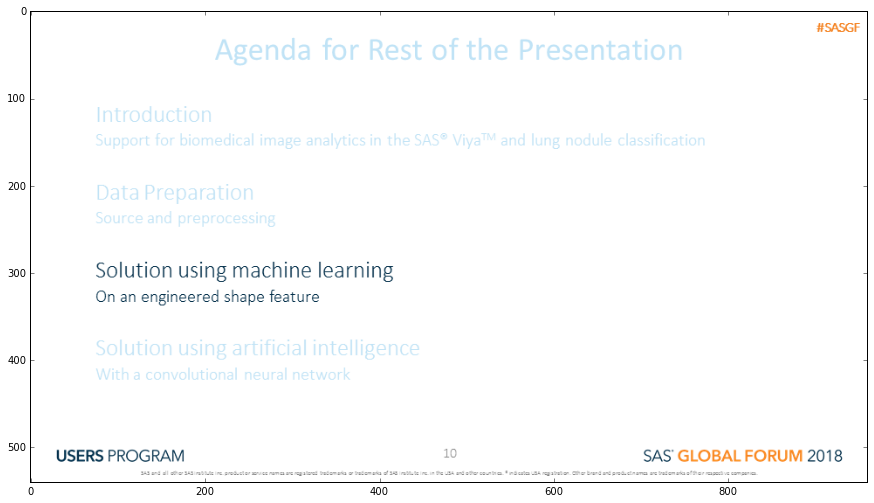

In [22]:
display_slide(slide_binaries, slide_paths, slide_width, slide_height, 10)

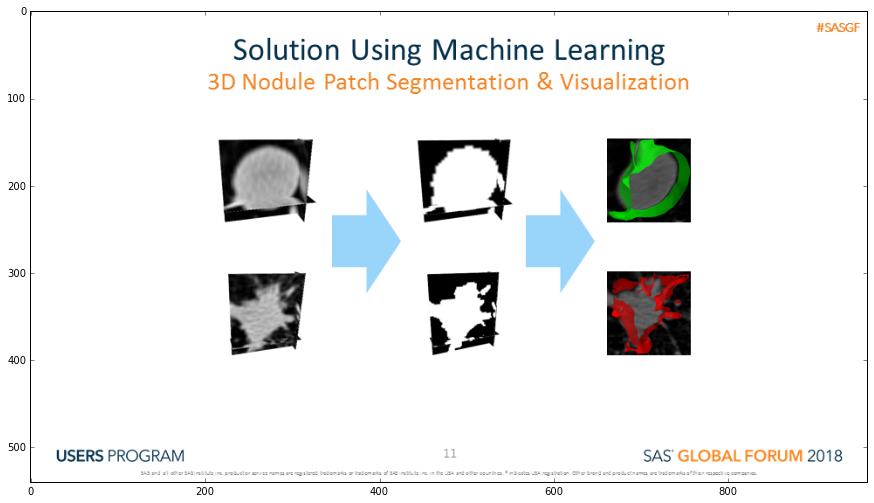

In [23]:
display_slide(slide_binaries, slide_paths, slide_width, slide_height, 11)

## Segment Nodules from the 3D Patches

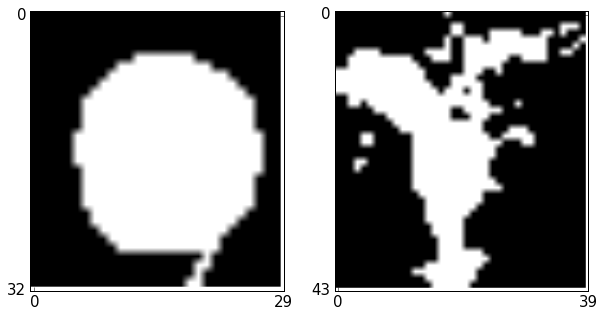

In [24]:
cvars = ['_diagnosis_', '_pid_']
cvarspgm = "_diagnosis_=scan(_label_, 1, '" + slash + "'); _pid_=scan(_label_, 2, '" + slash + "')"
nodules_3d.append_computed_columns(cvars, cvarspgm)

masks_3d = s.CASTable(name='masks3D', replace=True)

res=s.biomedimage.segmentbiomedimages(images=dict(table=nodules_3d),
                                      method=dict(name='kmeans', kmeansparameters=dict(kmeanstype='basic',
                                                                                       regions=2)),
                                      decode = True,
                                      copyvars=["_diagnosis_", "_pid_", "_path_", "_id_"],
                                      addcolumns=["position", "orientation", "spacing"],
                                      casOut=masks_3d)

# Display
display_image_pair_from_table(masks_3d, 1, "_pid_='CT-Training-BE007'", "_pid_='CT-Training-LC009'")

## Visualize the Segmentations in 3D

### <font color='green'>(Prerun)</font> Build & Fetch Surfaces of 2 Nodules for Visualization

In [25]:
s.setsessopt(messageLevel='NOTE')

nodule_vertices = s.CASTable(name='noduleVertices', replace=True)
nodule_faces = s.CASTable(name='noduleFaces', replace=True)

surf_summary = s.biomedimage.buildsurface(images=dict(table=masks_3d.query("_pid_='CT-Training-BE007' or _pid_='CT-Training-LC009'")),
                                          intensities=[1],
                                          smoothing=dict(iterations=3),
                                          outputvertices=nodule_vertices,
                                          outputfaces=nodule_faces)
display(surf_summary)

surf_ids = surf_summary.Surfaces['Surface Identifier']
print('Fetching the surfaces ...', flush=True)
fetched_vertices = nodule_vertices.query('_surfaceId_=' + str(surf_ids[0]) + ' or ' + '_surfaceId_=' + str(surf_ids[1]))\
                                  .sort_values('_id_').to_frame()
fetched_faces = nodule_faces.to_frame()

if surf_summary.Surfaces['Number of Faces'][0] > surf_summary.Surfaces['Number of Faces'][1]:
    ben_surf_id=1
    mal_surf_id=0
else:
    ben_surf_id=0
    mal_surf_id=1

NOTE: Processed 2 images from Cloud Analytic Services table MASKS3D.


,Surface Identifier,Image Identifier,Low Threshold,High Threshold,Number of Vertices,Number of Faces
0,10,5,1.0,1.0,7087,12766
1,29,7,1.0,1.0,2479,4382


Fetching the surfaces ...


### Display routine

In [26]:
def display_nodulesurf_with_slice(fetched_vertices, fetched_faces, medical_dimensions, medical_formats,
                                  medical_binaries, medical_resolutions, medical_channelTypes, medical_spacings,
                                  medical_positions, medical_orientations, surf_id, pid, Z, patient_ids, rgb):
    print('Visualizing the surfaces ...', flush=True)

    vertices = fetched_vertices[fetched_vertices._surfaceId_ == surf_ids[surf_id]]
    faces = fetched_faces[fetched_faces._surfaceId_ == surf_ids[surf_id]]
    x = vertices.ix[:, ["_x_"]]
    y = vertices.ix[:, ["_y_"]]
    z = vertices.ix[:, ["_z_"]]
    flist = faces.ix[:, ["_v1_", "_v2_", "_v3_"]]
    op = 0.75
    mlab.triangular_mesh(x, y, z, flist, color=tuple([c/255 for c in rgb]), opacity=op)
    
    # Display the slices in the patient coordinate system
    print('Displaying the slices in the patient coordinate system ...', flush=True)
    display_slice_3d(medical_binaries, medical_dimensions, medical_resolutions, medical_formats,
                     medical_positions, medical_orientations, medical_spacings, (0, 1, 2), 0, int(Z[patient_ids==pid]), 1)
    mlab.show()

### Visualize a Benign Nodule With Original Image Slice

#### <font color='green'>(Prerun)</font> Fetch the Slice

In [27]:
# Fetch an example slice for the patient
pid_benign = 'CT-Training-BE007'
print('Fetching the image of ' + pid_benign + ' ...', flush=True)
fetched_rows_benign = orig_medical.query("_label_='" + pid_benign + "'").to_frame()
medical_dimensions_benign = fetched_rows_benign["_dimension_"]
medical_formats_benign = fetched_rows_benign["_channelType_"]
medical_binaries_benign = fetched_rows_benign["_image_"]
medical_resolutions_benign = fetched_rows_benign["_resolution_"]
medical_channelTypes_benign = fetched_rows_benign["_channelType_"]
medical_spacings_benign = fetched_rows_benign["_spacing_"]
medical_positions_benign = fetched_rows_benign["_position_"]
medical_orientations_benign = fetched_rows_benign["_orientation_"]

Fetching the image of CT-Training-BE007 ...


#### Display

In [28]:
display_nodulesurf_with_slice(fetched_vertices, fetched_faces, medical_dimensions_benign, medical_formats_benign,
                              medical_binaries_benign, medical_resolutions_benign, medical_channelTypes_benign, 
                              medical_spacings_benign, medical_positions_benign, medical_orientations_benign, 
                              ben_surf_id, pid_benign, Z, patient_ids, (0, 255, 0))

Visualizing the surfaces ...
Displaying the slices in the patient coordinate system ...


### Visualize a Malignant Nodule Along with Original Slice

#### <font color='green'>(Prerun)</font> Fetch

In [29]:
# Fetch an example slice for the patient
pid_malignant = 'CT-Training-LC009'
print('Fetching the image of ' + pid_malignant + ' ...', flush=True)
fetched_rows_malignant = orig_medical.query("_label_='" + pid_malignant + "'").to_frame()
medical_dimensions_malignant = fetched_rows_malignant["_dimension_"]
medical_formats_malignant = fetched_rows_malignant["_channelType_"]
medical_binaries_malignant = fetched_rows_malignant["_image_"]
medical_resolutions_malignant = fetched_rows_malignant["_resolution_"]
medical_channelTypes_malignant = fetched_rows_malignant["_channelType_"]
medical_spacings_malignant = fetched_rows_malignant["_spacing_"]
medical_positions_malignant = fetched_rows_malignant["_position_"]
medical_orientations_malignant = fetched_rows_malignant["_orientation_"]

Fetching the image of CT-Training-LC009 ...


#### Display

In [30]:
display_nodulesurf_with_slice(fetched_vertices, fetched_faces, medical_dimensions_malignant, medical_formats_malignant,
                              medical_binaries_malignant, medical_resolutions_malignant, medical_channelTypes_malignant, 
                              medical_spacings_malignant, medical_positions_malignant, medical_orientations_malignant, 
                              mal_surf_id, pid_malignant, Z, patient_ids, (255, 0, 0))

Visualizing the surfaces ...
Displaying the slices in the patient coordinate system ...


## Export 3D Nodule Masks as 2D Slices

In [31]:
cvars = ['_label_']
cvarspgm = "length _label_ varchar(*); _label_=_pid_;"
masks_3d.append_computed_columns(cvars, cvarspgm)

masks = s.CASTable(name='masks', replace=True)

res=s.biomedimage.processbiomedimages(images=dict(table=masks_3d),
                                      steps=[dict(stepparameters=dict(steptype='export'))],
                                      decode = True,
                                      copyvars={"_label_"},
                                      casout = masks)

NOTE: Processed 10 images from Cloud Analytic Services table MASKS3D.


## Resample All Patches to 32x32

NOTE: Table MASKS contains decompressed images.
NOTE: 110 out of 110 images were processed successfully and saved as decompressed images to the Cloud Analytic Services table masksScaled.


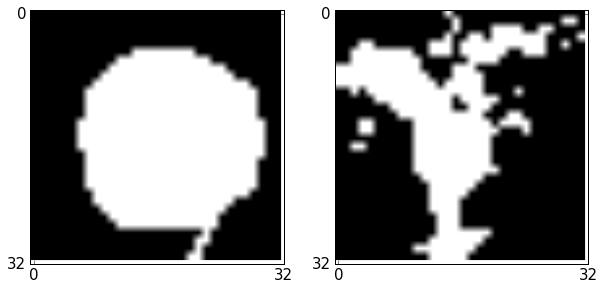

In [32]:
common_w = 32
common_h = 32
cvars = ['_path_']
cvarspgm = "length _path_ varchar(*); _path_=put(_bioMedId_*1000+_sliceIndex_, 5.);"
masks_in = s.CASTable(name='masks')
masks_in.append_computed_columns(cvars, cvarspgm)

masks_scaled = s.CASTable(name='masksScaled', replace=True)

s.image.processimages(imagetable=masks_in, 
                      casout=masks_scaled,
                      imagefunctions=[dict(functionoptions=dict(functiontype="resize", width=common_w, height=common_h)),
                                      dict(functionoptions=dict(functiontype="threshold", type="binary", value=0))],
                      decode=True)

# Display
display_image_pair_from_table(masks_scaled, 1, "_label_='CT-Training-BE007'", "_label_='CT-Training-LC009'")

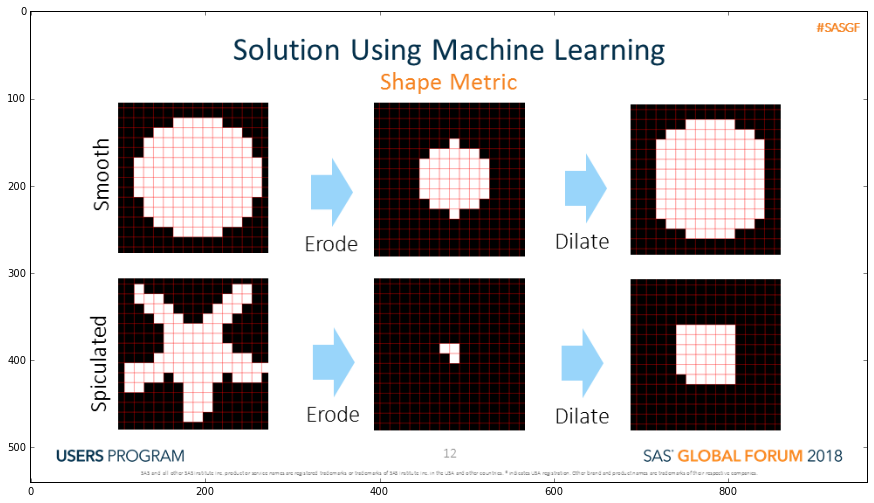

In [33]:
display_slide(slide_binaries, slide_paths, slide_width, slide_height, 12)

## Morphological Operations

NOTE: Table MASKSSCALED contains decompressed images.
NOTE: 110 out of 110 images were processed successfully and saved as decompressed images to the Cloud Analytic Services table masksFinal.


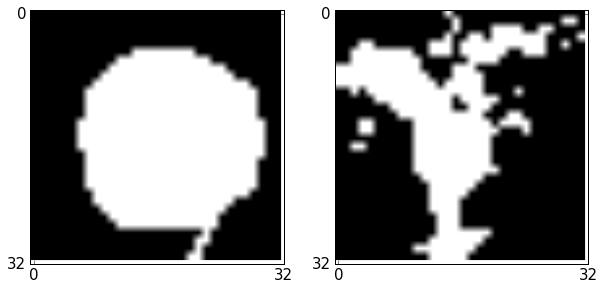

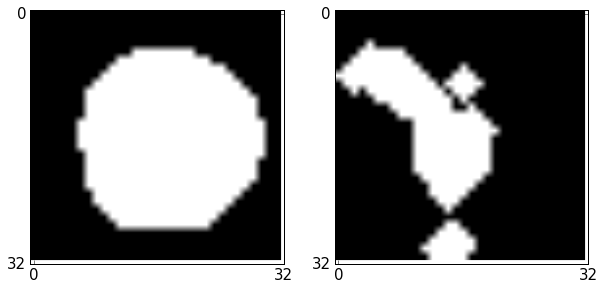

In [34]:
masks_scaled_in = s.CASTable('masksScaled')
masks_final = s.CASTable(name='masksFinal', replace=True)

s.image.processimages(imagetable=masks_scaled_in, 
                      casout=masks_final,
                      imagefunctions=[dict(functionoptions=dict(functiontype="morphology", method="erode",
                                                                kernelwidth=3, Kernelheight=3)),
                                      dict(functionOptions=dict(functionType="morphology", method="erode",
                                                                kernelwidth=3, Kernelheight=3)),
                                      dict(functionOptions=dict(functionType="morphology", method="dilate",
                                                                kernelwidth=3, Kernelheight=3)),
                                      dict(functionOptions=dict(functionType="morphology", method="dilate",
                                                                kernelwidth=3, Kernelheight=3)),],
                      decode=True)

# Display
display_image_pair_from_table(masks_scaled, 1, "_label_='CT-Training-BE007'", "_label_='CT-Training-LC009'")
display_image_pair_from_table(masks_final, 1, "_label_='CT-Training-BE007'", "_label_='CT-Training-LC009'")

## Convert Before & After Images to Wide Format

In [35]:
# Convert before & after images to color
masks_scaled_color = s.CASTable(name='masksScaledColor', replace=True)
masks_scaled_color_in = s.CASTable(name='masksScaledColor')
s.image.processimages(imagetable=masks_scaled_in, 
                      casout=masks_scaled_color,
                      imagefunctions=[dict(functionoptions=dict(functiontype="convert_color", type="gray2color"))],
                      decode=True)

masks_final_in = s.CASTable('masksFinal')
masks_final_color = s.CASTable(name='masksFinalColor', replace=True)
masks_final_color_in = s.CASTable(name='masksFinalColor')
s.image.processImages(imagetable=masks_final_in, 
                      casout=masks_final_color,
                      imagefunctions=[dict(functionoptions=dict(functiontype="convert_color", type="gray2color"))],
                      decode=True)

# Convert before & after images to wide format
masks_scaled_flat = s.CASTable('masksScaledFlat', replace=True)
s.image.flattenimagetable(imagetable=masks_scaled_color_in,
                          casout=masks_scaled_flat,
                          width=common_w,
                          height=common_h)
masks_final_flat = s.CASTable('masksFinalFlat', replace=True)
s.image.flattenimagetable(imagetable=masks_final_color_in,
                          casout=masks_final_flat,
                          width=common_w,
                          height=common_h)


# Fetch sample rows & display
fetched_flat = masks_scaled_flat.head(3)
display(HTML("<h3>BEFORE morphological operations</h3>"))
midc = 'c1100'
display(fetched_flat[['_path_', 'c1', 'c2', 'c3', midc, 'c3072', '_label_']])
fetched_flat = masks_final_flat.head(3)
display(HTML("<h3>AFTER morphological operations</h3>"))
display(fetched_flat[['_path_', 'c1', 'c2', 'c3', midc, 'c3072', '_label_']])

NOTE: Table MASKSSCALED contains decompressed images.
NOTE: 110 out of 110 images were processed successfully and saved as decompressed images to the Cloud Analytic Services table masksScaledColor.
NOTE: Table MASKSFINAL contains decompressed images.
NOTE: 110 out of 110 images were processed successfully and saved as decompressed images to the Cloud Analytic Services table masksFinalColor.
NOTE: Table MASKSSCALEDCOLOR contains decompressed images.
NOTE: 110 out of 110 images were processed successfully and saved to the Cloud Analytic Services table masksScaledFlat.
NOTE: Table MASKSFINALCOLOR contains decompressed images.
NOTE: 110 out of 110 images were processed successfully and saved to the Cloud Analytic Services table masksFinalFlat.


,_path_,c1,c2,c3,c1100,c3072,_label_
0,1000,0.0,0.0,0.0,0.0,0.0,CT-Training-LC003
1,1001,0.0,0.0,0.0,0.0,0.0,CT-Training-LC003
2,1002,0.0,0.0,0.0,0.0,0.0,CT-Training-LC003


,_path_,c1,c2,c3,c1100,c3072,_label_
0,1000,0.0,0.0,0.0,0.0,0.0,CT-Training-LC003
1,1001,0.0,0.0,0.0,0.0,0.0,CT-Training-LC003
2,1002,0.0,0.0,0.0,0.0,0.0,CT-Training-LC003


## Add Up the White Pixels in All Images & Fetch the Results

In [36]:
# Create the program for sum of all columns
pgm = "nz = c1";
for num in range(2, common_w*common_h*3 + 1):
    pgm += "+c" + str(num)
    

# Fetch the tables with #white pixels in each of the slices computed
masks_scaled_flat.append_computed_columns("nz", pgm)
scaled_sum = masks_scaled_flat[['_path_', '_label_', 'nz']].to_frame()
masks_final_flat.append_computed_columns("nz", pgm)
final_sum = masks_final_flat[['_path_', 'nz']].to_frame()

# Fetch sample rows to the client side & display
display(HTML("<h3>BEFORE morphological operations</h3>"))
display(scaled_sum[['_path_', 'nz', '_label_']][0:3])
display(HTML("<h3>AFTER morphological operations</h3>"))
display(final_sum[['_path_', 'nz']][0:3])

,_path_,nz,_label_
0,1000,10710.0,CT-Training-LC003
1,1001,39015.0,CT-Training-LC003
2,1002,91800.0,CT-Training-LC003


,_path_,nz
0,1000,0.0
1,1001,0.0
2,1002,70380.0


## Compute Degree of Spiculation: Relative Amount of Pixels "Lost" During Morphological Operations

In [37]:
# Join the 2 tables on file path
joined_sum = pd.merge(scaled_sum, final_sum, on='_path_', suffixes=['s', 'f'])
good = joined_sum['nzs']!=0
joined_sum = pd.merge(joined_sum, fetched_labels[['PatientID', 'Diagnosis']], left_on='_label_', right_on='PatientID')
good = joined_sum['nzs']!=0
fetched_spiculations = (joined_sum['nzs'][good]-joined_sum['nzf'][good])/joined_sum['nzs'][good]
fetched_diagnosis = joined_sum['Diagnosis'][good]
plot_data = np.column_stack((fetched_spiculations, fetched_diagnosis.T))
print(plot_data[0:10])
n_images = len(plot_data)

[[1.0 'malignant']
 [1.0 'malignant']
 [0.23333333333333334 'malignant']
 [0.19649122807017544 'malignant']
 [0.14136125654450263 'malignant']
 [0.10182767624020887 'malignant']
 [0.0633245382585752 'malignant']
 [0.1242603550295858 'malignant']
 [0.12444444444444444 'malignant']
 [0.40425531914893614 'malignant']]


# Plot the Distribution of Degree of Spiculation for Each Class

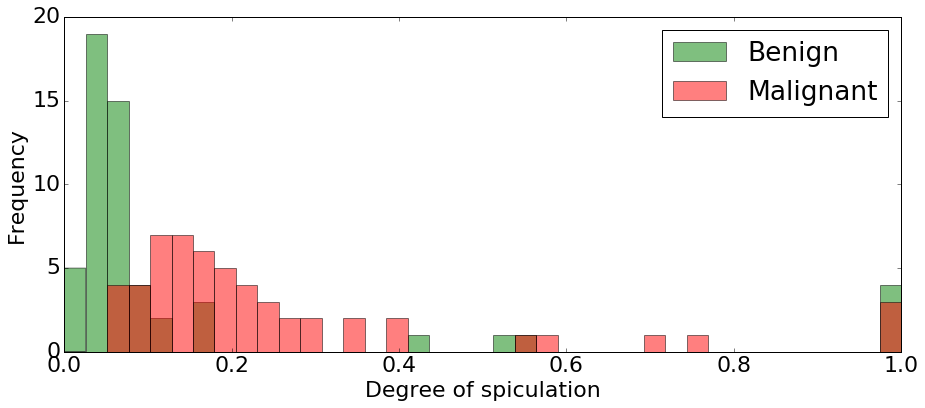

In [38]:
# Plot histograms for spiculation for each label
fig, ax = plt.subplots(figsize=(15, 6))
bar_width = 0.7
opacity = 0.5
bins = np.linspace(0, 1, 40)
inds = fetched_diagnosis == 'benign'
plt.hist(fetched_spiculations[inds], bins, alpha=opacity, label='Benign', color='g')
inds = fetched_diagnosis == 'malignant'
plt.hist(fetched_spiculations[inds], bins, alpha=opacity, label='Malignant', color='r')
matplotlib.rcParams.update({'font.size': 22})
plt.xlabel('Degree of spiculation')
plt.ylabel('Frequency')
plt.legend()
plt.show()

# Plot ROC Curve for the Metric & Calculate Optimal Threshold

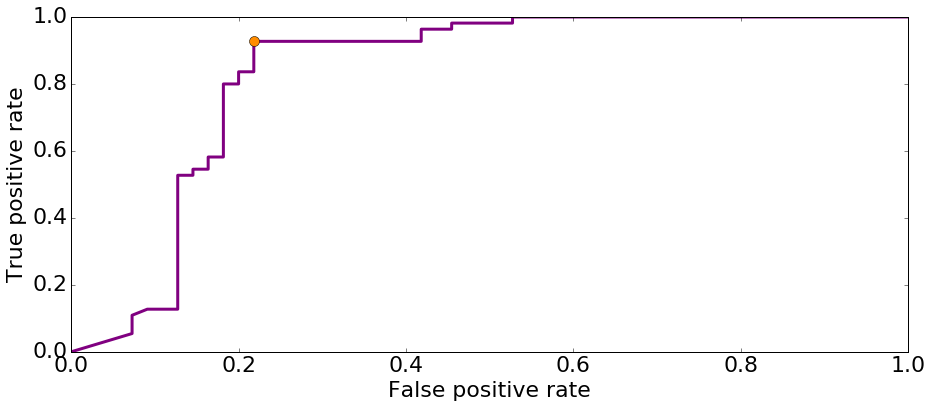

In [39]:
optt, fpr, tpr, thresholds = find_optimal_cutoff(fetched_diagnosis, fetched_spiculations, 'malignant')
fig, ax = plt.subplots(figsize=(15, 6))
plt.plot(fpr, tpr, color='#800080', linewidth=3.0)
plt.plot([fpr[i] for i in range(len(thresholds)) if thresholds[i] == optt[0]], 
         [tpr[i] for i in range(len(thresholds)) if thresholds[i] == optt[0]],
         marker='o', color='#FF8C00', markersize=10)
matplotlib.rcParams.update({'font.size': 22})
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()
display(HTML("<h3>Optimal spiculation cut off: %s" % optt[0] + "<h3>"))

# Assess the Metric Accuracy With k-Fold Cross Validation

In [40]:
n_folds = 10
kf = model_selection.KFold(n_splits=n_folds)

acc=[]
for train_index, test_index in kf.split(fetched_spiculations):
    ot, f, t, ts = find_optimal_cutoff(fetched_diagnosis[train_index], fetched_spiculations[train_index], 'malignant')
    acc.extend([sum(1 for i in test_index if (fetched_spiculations[i] >  ot and fetched_diagnosis[i] == 'malignant') or
                                             (fetched_spiculations[i] <= ot and fetched_diagnosis[i] == 'benign')) / len(test_index) * 100])

display(HTML("<h3>Classification accuracy based on %s -fold cross-validation: %s" % (n_folds, np.mean(acc)) + "<h3>"))

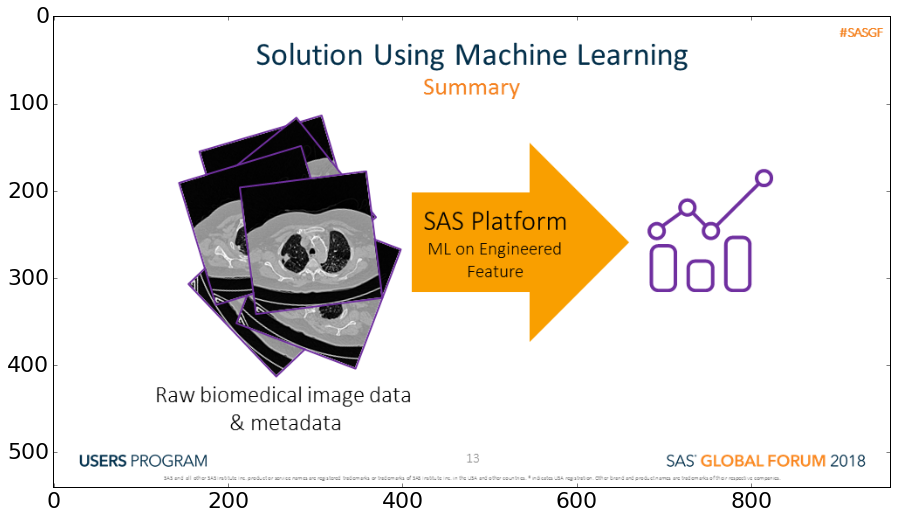

In [41]:
display_slide(slide_binaries, slide_paths, slide_width, slide_height, 13)

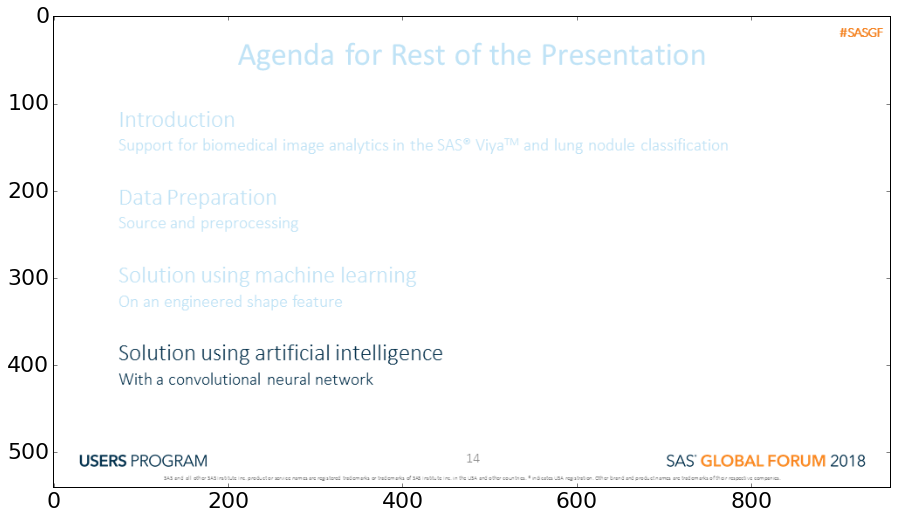

In [42]:
display_slide(slide_binaries, slide_paths, slide_width, slide_height, 14)

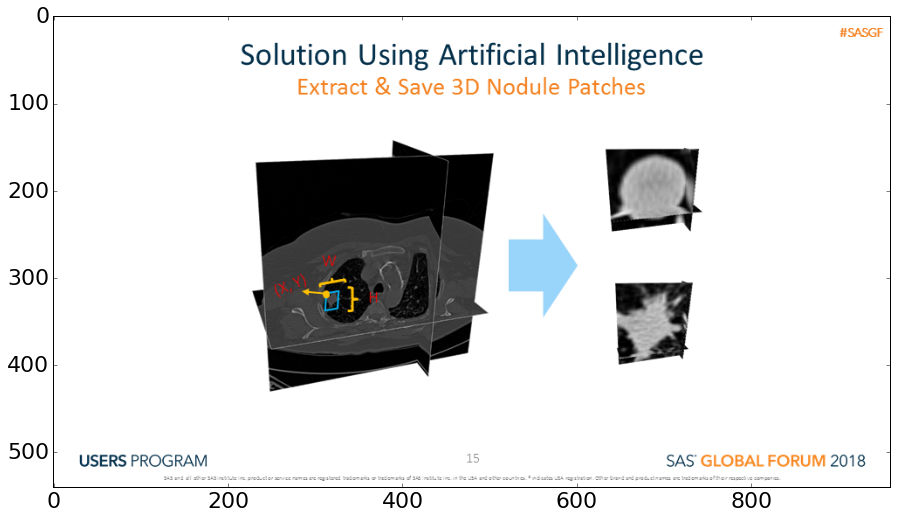

In [43]:
display_slide(slide_binaries, slide_paths, slide_width, slide_height, 15)

# Resample 3D Nodule Patches and Export Them as 2D Slices

NOTE: Processed 10 images from Cloud Analytic Services table NODULES3D.


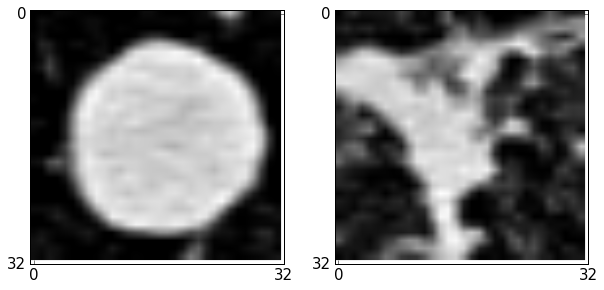

In [44]:
cvars = ['_diagnosis_', '_pid_']
cvarspgm = "_diagnosis_=SCAN(_label_, 1, '" + slash + "'); _pid_=SCAN(_label_, 2, '" + slash + "')"
nodules_3d.append_computed_columns(cvars, cvarspgm)

nodules_2d = s.CASTable(name='nodules2D', replace=True)

res = s.biomedimage.processbiomedimages(images=dict(table=nodules_3d),
                                        steps=[dict(stepparameters=dict(steptype='resample', 
                                                                        resampleparameters=dict(resampletype='size', 
                                                                                                width=common_w, 
                                                                                                height=common_h))),
                                               dict(stepparameters=dict(steptype='export'))],
                                        decode=True,
                                        copyVars=["_diagnosis_", "_pid_", "_path_", "_id_"],
                                        casOut=nodules_2d)

display_image_pair_from_table(nodules_2d, 1, "_pid_='CT-Training-BE007'", "_pid_='CT-Training-LC009'")

# Shuffle Images & Create Training & Testing Sets

In [45]:
cvars = ['_label_', 'shuffle_id']
cvarspgm = "length _label_ varchar(*); _label_=_diagnosis_; call streaminit(-1); shuffle_id=rand(\"UNIFORM\");"
pThreshold = '0.5'
nodules_2d.append_computed_columns(cvars, cvarspgm)

trainTbl0 = nodules_2d.query('shuffle_id>'+pThreshold).groupby('shuffle_id')
train = s.CASTable('train', replace=True)
r = s.partition(table=trainTbl0, casout=train)

validTbl0 = nodules_2d.query('shuffle_id<'+pThreshold).groupby('shuffle_id')
test = s.CASTable('test', replace=True)
r = s.partition(table=trainTbl0, casout=test)

# Agument Training Data

NOTE: Table TRAIN contains decompressed images.
NOTE: 648 images were produced successfully out of 54 input images and saved as decompressed images to the Cloud Analytic Services table trainAug.


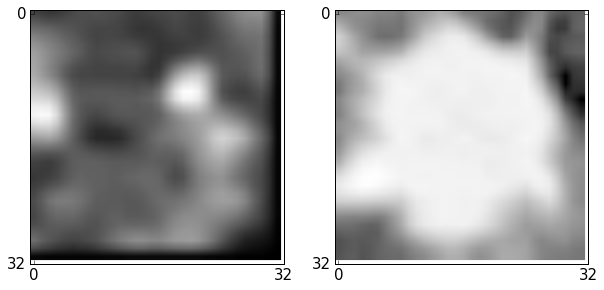

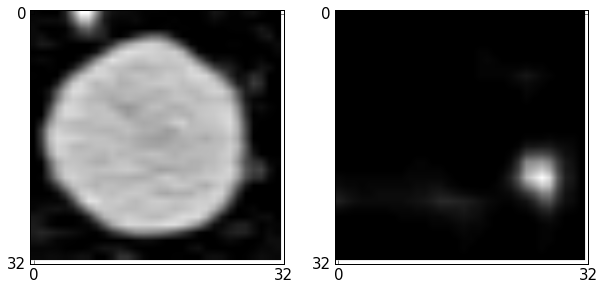

In [46]:
train_in = s.CASTable('train')
train_aug = s.CASTable('trainAug', replace=True)
s.image.augmentImages(imageTable=train_in,
                      cropList=[{'useWholeImage': True,
                                 'mutations': {
                                 'verticalFlip': True,
                                 'horizontalFlip': True,
                                 'sharpen': True,
                                 'darken': True,
                                 'lighten': True,
                                 'colorJittering': True,
                                 'colorShifting': True,
                                 'rotateRight': True,
                                 'rotateLeft': True,
                                 'pyramidUp': True,
                                 'pyramidDown': True}}],
                      copyvars=['_pid_'],
                      casout=train_aug)

n_ids = 100
fetched_ids = train_aug[['_id_']].to_frame(to=n_ids+1)['_id_']
display_image_pair_from_table(train_aug, 1, "_id_="+str(fetched_ids[randint(0, n_ids)]), 
                                            "_id_="+str(fetched_ids[randint(0, n_ids)]))
display_image_pair_from_table(train_aug, 1, "_id_="+str(fetched_ids[randint(0, n_ids)]), 
                                            "_id_="+str(fetched_ids[randint(0, n_ids)]))

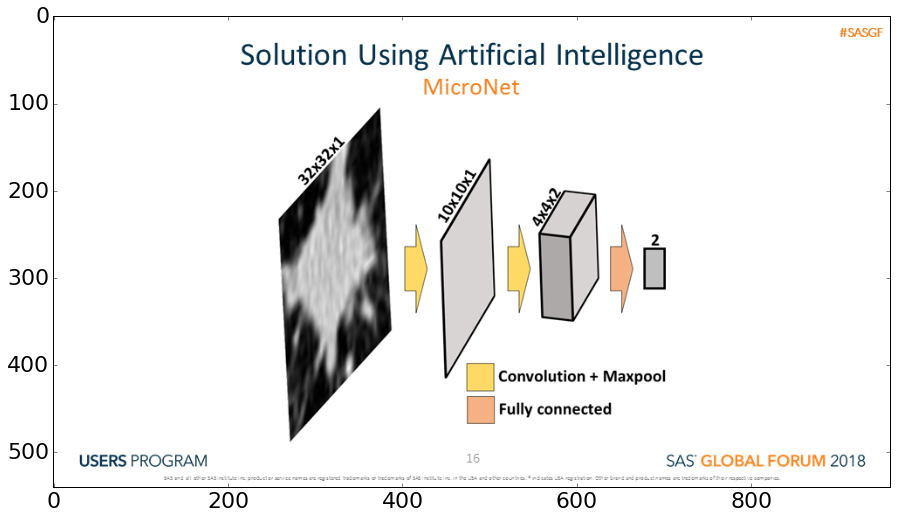

In [47]:
display_slide(slide_binaries, slide_paths, slide_width, slide_height, 16)

# Build the CNN, the MicroNet

In [48]:
# Create the model tinyNet
micro_net = s.CASTable('microNet', replace=True)
micro_net_in = s.CASTable('microNet')
s.deepLearn.buildModel(model=micro_net, type='CNN')

# Input layer
s.deepLearn.addLayer(model=micro_net_in, name='images', 
                     layer=dict(type='input', nchannels=1, width=32, height=32))

# First Convolutional Layer
s.deepLearn.addLayer(model=micro_net_in, name='conv1',
                     layer=dict(type='convolution', nFilters=1, width=3, height=3, stride=1,
                     init='NORMAL', std=0.1, truncationfactor=2, act='RELU'),
                     srcLayers=['images'])

# First pooling layer
s.deepLearn.addLayer(model=micro_net_in, name='pool1',
                     layer=dict(type='pooling', width=3, height=3, stride=3, pool='max'),
                     srcLayers=['conv1'])
                      
# Second Convolutional Layer
s.deepLearn.addLayer(model=micro_net_in, name='conv2',
                     layer=dict(type='convolution', nFilters=2, width=3, height=3, stride=1,
                     init='NORMAL', std=0.1, truncationfactor=2, act='RELU'),
                     srcLayers=['pool1'])

# Second pooling layer
s.deepLearn.addLayer(model=micro_net_in, name='pool2',
                     layer=dict(type='pooling', width=2, height=2, stride=2, pool='max'),
                     srcLayers=['conv2'])
                      
# Fully connected layer
s.deepLearn.addLayer(model=micro_net_in, name='fc1', 
                     layer=dict(type='fullconnect', n=2, act='relu', init='NORMAL', std=0.1, truncationfactor=2),
                     srcLayers=['pool2'])

# Softmax output layer
r = s.deepLearn.addLayer(model=micro_net_in, name='outlayer', 
                         layer=dict(type='output', act='softmax'),
                         srcLayers=['fc1'])
r

,casLib,Name,Rows,Columns,casTable
0,lcdemo,micronet,101,5,"CASTable('micronet', caslib='lcdemo')"


# <font color='green'>(Prerun)</font> Train MicroNet

In [49]:
# Train the model (this took over an hour with the 10 workers)
s.setsessopt(messageLevel='ERROR')
train_r = s.deepLearn.dltrain(model=micro_net_in,
                              table=train_aug,
                              seed=99,
                              nthreads=8,
                              input=['_image_','_label_'],
                              target='_label_',
                              nominal=['_label_'],
                              modelweights=dict(name='weights', replace=True),
                              learningOpts=dict(miniBatchSize=1, maxEpochs=20, learningRate=0.001, aSyncFreq=1, algorithm='ADAM'))
s.setsessopt(messageLevel='NOTE')
display(HTML("<h3>Number of parameters in MicroNet: %s" %  str(train_r.ModelInfo['Value'][10] + "<h3>")))

# Plot Training Loss/Fit

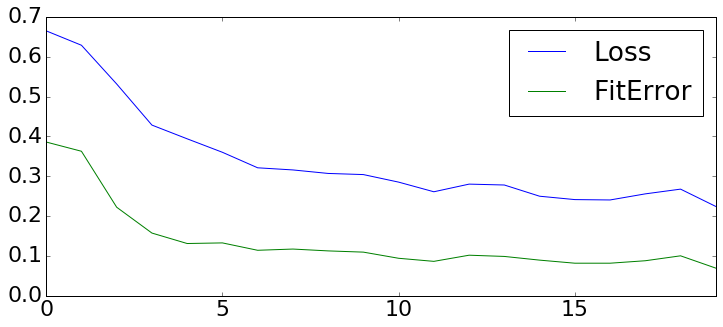

In [50]:
train_r.OptIterHistory[['Loss', 'FitError']].plot(figsize = (12, 5));

# Test MicroNet

In [51]:
# Score against validation data
weights = s.CASTable('weights', replace=True)
scored = s.CASTable('scored', replace=True)
r = s.dlscore(model=micro_net_in,
              initWeights=weights,
              table=test,
              copyVars=['_label_', "_image_"],
              layerOut=dict(name='layerOut', replace=True),
              casout=scored)
display(HTML("<h3>Misclassification error: %s" %  str(r.ScoreInfo['Value'][2] + "<h3>")))

# Confusion Matrix

In [52]:
# build a confusion matrix 
cmr = s.crosstab(table=scored, row='_label_', col='_dl_predname_')
cmr

,_label_,Col1,Col2
0,benign,32.0,2.0
1,malignant,3.0,18.0


# False Positive Example

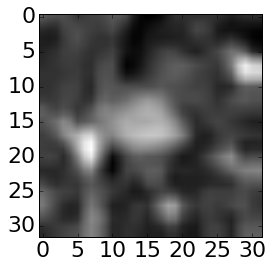

In [53]:
wc = "_label_='benign' and _dl_predname_='malignant'"
scored_images = scored.query(wc).to_frame()
if (len(scored_images)):
    image = np.array(bytearray(scored_images['_image_'][0][0:32*32]))
    image = np.reshape(image, [32, 32])
    plt.imshow(image)
    plt.show()
else:
    display(HTML("<h3> No false positives! <h3>"))

# False Negative Example

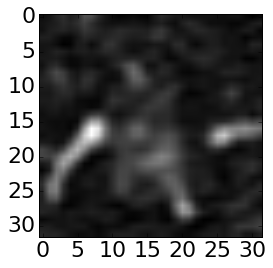

In [54]:
wc = "_label_='malignant' and _dl_predname_='benign'"
scored_images = scored.query(wc).to_frame()
if (len(scored_images)):
    image = np.array(bytearray(scored_images['_image_'][0][0:32*32]))
    image = np.reshape(image, [32, 32])
    plt.imshow(image)
    plt.show()
else:
    display(HTML("<h3> No false negatives! <h3>"))

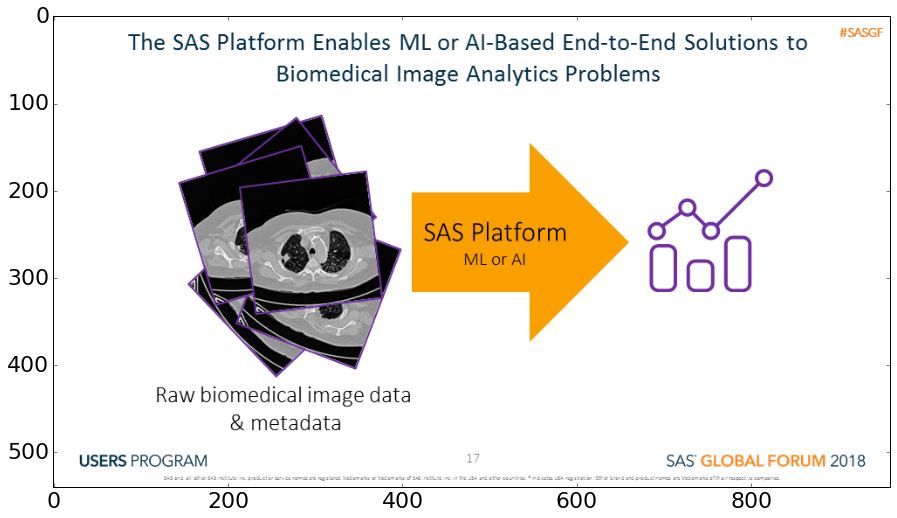

In [55]:
display_slide(slide_binaries, slide_paths, slide_width, slide_height, 17)

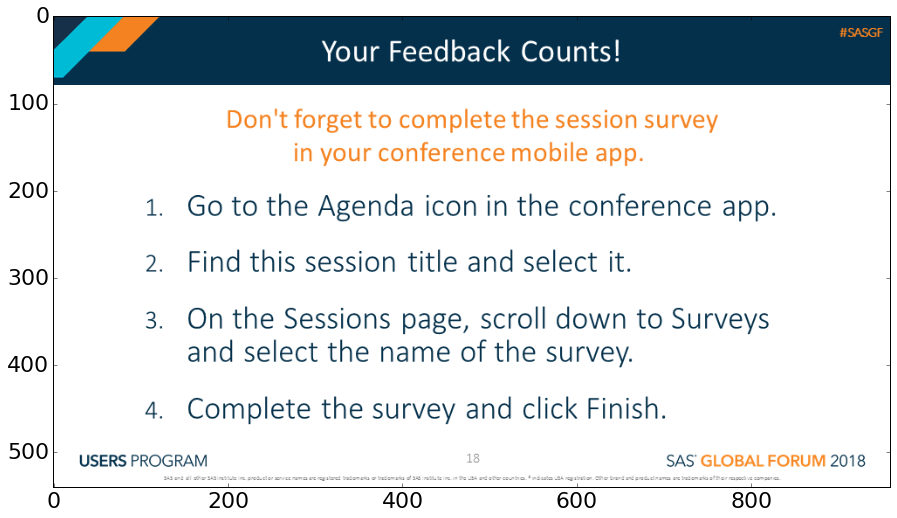

In [56]:
display_slide(slide_binaries, slide_paths, slide_width, slide_height, 18)